# EE-411 Fundamentals of inference and learning, EPFL 
## Exercise Session 1: looking at data with python and pandas

In this first set of exercices, we will start the course by solving some simple python problems that will help you warm up for the future. We advise you to run python notebooks on your browser, for instance using google colab (Watch <a href="https://https://www.youtube.com/watch?v=RLYoEyIHL6A">Introduction to Colab</a> to find out more) or our own serveur in epfl (on <a href="https://noto.epfl.ch/">noto.epfl.ch</a>). If you need to refresh your python skills, you may start by our introductory notebooks [here](https://github.com/IdePHICS/FundamentalLearningEPFL2021/blob/main/TP0/Intro%20to%20Python.ipynb) and [there](https://github.com/IdePHICS/FundamentalLearningEPFL2021/blob/main/TP0/Visualization.ipynb).

**What you will learn today:** In this first session, we will discuss briefly how to use python, how to use pandas (a powerful, and easy to use, open source data analysis and manipulation tool), and discuss the idea of permutation test and bootstrap, that are amazingly useful concepts from statistics.



# The Brexit data: who wanted out?


We will introduce the concept of permutation test in the hypothesis testing problem exploiting a cool analysis on the Brexit referendum following this great resource https://matthew-brett.github.io/les-pilot/brexit_ages.html. This will give us the opportunity to review the basic functionalities of pandas, a pivotal package in data-handling which we will find often during this course. In fact, you may want to follow an introduction to pandas (for instance [this one](https://www.learndatasci.com/tutorials/python-pandas-tutorial-complete-introduction-for-beginners/), or the very useful [Most Important Pandas Functions for Data Science](https://www.analyticsvidhya.com/blog/2021/05/pandas-functions-13-most-important/)
).

Here is our problem: The Hansard society made a poll in the 2016 interviewing 1771 people on the Brexit referendum  (data available here https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=8183).


If we dig into the data, we see that the average age of the "Brexiteers" is higher from the one of the "Remainers". 
We are interested in addressing the following question: how $\textbf{confident}$ can we be that this rule is general and is not an artifact due to low sample size? 


This problem falls in the broader context of hypothesis testing problem:

* Hypothesis (H1) - effective difference in the age of Brexiteers and Remainers 
                       
                         vs 
                         
* "Null hypothesis" (H0) - no difference in the age of the two groups

This seems like a hard problem but we will see that with a very simple idea we will be able to characterize the answer. Let's proceed by small steps and let's understand how to handle a dataset with pandas.


### $\color{white}{\text{Data-handling with pandas }}$ 

In [ ]:
# Let's import the package 
import pandas as pd

In [ ]:
# Read data using pd.read_csv obtaining a "data frame" (df) object
data_raw = pd.read_csv('https://raw.githubusercontent.com/IdePHICS/FundamentalLearningEPFL/main/TP1/audit_of_political_engagement_14_2017.tab', sep = '\t')

The way pandas datas is presented look messy at first. It is called a **dataframe**. By printing the data frame, this is what we see:

In [ ]:
data_raw

Typically, one would start by looking the first lines, using:

In [ ]:
data_raw.head()

Another useful pandas tool is `describe`, that is used to generate descriptive statistics of the data in a Pandas DataFrame


In [ ]:
data_raw.describe()

In these dats, the different columns correspond to different $\textbf{features}$, many of these are useless for our goals since we are interested just in the age of the person and how she/he voted. The line corresponds to all the people that were interviewed.  The code for this two features are respectively "cut15" and "numage", let's focus on them and change the nomenclature for having a new nice-looking dataframe.




In [ ]:
# Feature selection
data = data_raw[['numage', 'cut15']]
# Rename columns
data.columns = ['age', 'vote']

The possible answer to the question - How did you vote on the question ‘Should the United Kingdom remain a member of the European Union or leave the European Union’?” - are encoded through $\textbf{labels}$, i.e. a number going from 1 to 6 encoding what was the answer:

Value = 1.0 $\qquad$ Label = Remain a member of the European Union

Value = 2.0 $\qquad$   Label = Leave the European Union

Value = 3.0 $\qquad$   Label = Did not vote

Value = 4.0 $\qquad$   Label = Too young

Value = 5.0 $\qquad$   Label = Can't remember

Value = 6.0 $\qquad$   Label = Refused

In [ ]:
# Let's see how it looks like now
data.head()

We can use `data.sort_values` to sort the dataset by age

In [ ]:
data.sort_values(by='age')

We must do again a feature selection since we want to analyze just the age of Brexiteers and Remainers and because we see that there are some artifacts in the age column (many zeros appearing). 

In [ ]:
# Remove zeros in the age column 
data = data[data['age'] != 0]

# Create the remainer and brexiters data frames by selecting the vote 
remainers = data[data['vote'] == 1]
brexiteers = data[data['vote'] == 2]

# We actually have in this poll less brexiteers than remainers, we compute using the function "len"
print(f"The percentage of brexiteers is {len(brexiteers)/(len(brexiteers) + len(remainers))}")

Let's have a look at the age distribution for the two. We import `matplotlib` for doing so, another well-known and important package that we shall use all the time.


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1,2, figsize=(20,7), sharex=True)
plt.suptitle("Age distribution", fontsize=16)
ax[0].set_title(f"Brexiteers", fontsize=14)
ax[0].hist(brexiteers['age'], color ='darkred')
ax[0].set_xlabel("Age", fontsize = 14)
ax[0].set_ylabel("# (people)", fontsize = 14)

ax[1].set_title(f"Remainers", fontsize=14)
ax[1].hist(remainers['age'], color ='darkblue')
ax[1].set_xlabel("Age", fontsize = 14)
ax[1].set_ylabel("# (people)", fontsize = 14)


Let's compute now the averages and compare them, using another well-known python package:

In [ ]:
import numpy as np

avg_brex = np.mean(brexiteers['age'])
avg_rem = np.mean(remainers['age'])

dataset_property = avg_brex - avg_rem
print(f"The difference in average age is {dataset_property}")

### $\color{white}{\text{Hypothesis testing}}$ 

Let's answer the very first question we asked ourselves: how can we quantify our level of confidence in stating that this difference is $\textbf{NOT}$ given by low sample-size effect? 

The answer is incredibly fascinating in its simplicity and effectiveness. The idea is the following: 
* *Create new datasets by permuting randomly the labels* 
* *Compute the differences in this new randomly drawn datasets*
* *See how many times the differences are higher than the experimental one*

We must create equivalent datasets made of a randomized group of 541 people (Group A) and another made of 774 (Group B) corresponding to what previously were respectively brexiteers and remainers.

In [ ]:
# Create a list with all ages

global_stat = list(brexiteers['age']) +  list(remainers['age'])

print(len(global_stat))

Import random package for computing random permutations

In [ ]:
import random 

Let's create 10000 new shuffled datasets and let's keep track when one difference in average ages is greater than the observed experimental one

In [ ]:
trials = 10000  ; count = 0

for dumb in range(trials):
    # Compute shuffled ages
    random.shuffle(global_stat)
    # Compute average of Group A
    avg_A = sum(global_stat[:541])/541 
    # Compute average of Group B
    avg_B = sum(global_stat[541:])/774 
    # Compute new shuffled difference 
    diff = avg_A - avg_B
    if diff > dataset_property:
        count +=1

...and we finally arrive to the result

In [ ]:
print(f"The average age of Group A was less than the one of Group B {count} times") 

We could safely $\textbf{reject}$ the null hypothesis 

## $\color{white}{\text{Bootstrap}}$ 

**Bootstrap** is a resampling strategy with replacement that requires no assumptions about the data distribution. 

It allows us to make inferences about the population statistics when we only have a finite number of samples. In the following we will see how to use it to evaluate the **confidence interval** and the **variance** of an estimator, but it has many other applications.

Even when we only have one sample, the bootstrap method provides a good enough approximation of the true population statistics.

### $\color{white}{\text{Bootstrap and Confidence Interval}}$

Question: **With one sample, how can we calculate the Confidence Interval for the median age of the Brexiteers and Remainers?**

Let's recall the dataset and isolate the age feature.

To do so we take a single column of the dataset, which is an object called `Series`, and turn it into a `numpy.ndarray` using `pd.Series.to_numpy`

In [ ]:
brexit_ages = pd.Series.to_numpy(brexiteers['age'])
remain_ages = pd.Series.to_numpy(remainers['age'])

First of all we compute the median for the two groups.

Firstly try to do it by hand, building the function *median_value()*:

In [ ]:
def median_value(array):
    set = np.sort(array)
    len = np.size(set)

    if (len % 2 == 0):
        median = (set[(len//2)-1] + set[len//2]) / 2
    else:
        median = set[len//2]
        
    return median 

In [ ]:
#Printing the median age of brexiteers and remainers
print(median_value(brexit_ages))
print(median_value(remain_ages))

Alternatively, one can use the `numpy` library and directly compute the median

In [ ]:
print(f"The median age of brexiteers is {np.median(brexit_ages)} while the one of remainers is {np.median(remain_ages)}")

Now we use **bootstrap**: we repeatedly sample the two groups with replacement with the same sample size

Fist we start with Brexiteers, choosing $10000$ as the number of repetitions of the sampling

In [ ]:
n = len(brexit_ages)

reps =10000

We then use 

```
np.random.choice(a, size=None, replace=True, p=None)
```

which generates a random sample of a certain size from a given 1-D array `a`. If `replace=True`, then a value of `a` can be selected multiple times.


In [ ]:
np.random.seed(123)

boot_brexit = np.random.choice(brexit_ages, (reps,n))
boot_brexit_medians = np.median(boot_brexit, axis=1)

The results look like this

In [ ]:
boot_brexit[:5]

In [ ]:
boot_brexit_medians[:5]

Now we can compute the standard deviation and the confidence interval

In [ ]:
print(f"The mean of the median age of brexiteers computed with bootstrap is {boot_brexit_medians.mean()} ")

In [ ]:
print(f"The standard deviation of the median age of brexiteers computed with bootstrap is {boot_brexit_medians.std()} ")

For the C.I. we use `np.percentile` to compute which range of values you can be 95% confident contains the true mean of the median

In [ ]:
boot_brexit_median_CI = np.percentile(boot_brexit_medians, [2.5,97.5])
print(f"The C.I. for the median age of brexiteers computed with bootstrap is [{boot_brexit_median_CI[0]},{boot_brexit_median_CI[1]}] ")

Now try to do the same for remainers

In [ ]:
n = len(remain_ages)
reps = 10000
np.random.seed(123) # Pseudonumbers, I fix a seed so that every time I run the program I get the same random numbers

boot_remainers = np.random.choice(remain_ages, (reps,n))
boot_remainers_median = np.median(boot_remainers, axis=1)

In [ ]:
print(f"The mean of the median age of remainers computes with bootstrap is {boot_remainers_median.mean()}")
print(f"The standart deviation of the median age of remainers computed with boostrap is {boot_remainers_median.std()}")

boot_remainers_median_CI = np.percentile(boot_remainers_median, [2.5,97.5])
print(f"The C.I. for the median age of remainers computed with bootstrap is [{boot_remainers_median_CI[0]},{boot_remainers_median_CI[1]}]")

Now we plot the median age distributions with the respective confidence intervals

In [ ]:
# Adapting variables name
boot_remain_medians = boot_remainers_median
boot_remain_median_CI = boot_remainers_median_CI

fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
plt.title("Median age distribution", size = 16)
# I plot the istogram
ax.hist(boot_brexit_medians, color ='darkred', label = f"Brexiteers")
# I plot the interval
plt.axvline(boot_brexit_median_CI[0],color = 'red',linewidth=2)
plt.axvline(boot_brexit_median_CI[1],color = 'red',linewidth=2)
# I plot the istogram
ax.hist(boot_remain_medians, color ='darkblue', label = f"Remainers")
# I plot the interval
plt.axvline(boot_remain_median_CI[0],color = 'blue',linewidth=2)
plt.axvline(boot_remain_median_CI[1],color = 'blue',linewidth=2)
# Name of x axe
ax.set(xlabel ="Age" , ylabel = "#(occurrences)")
ax.legend();

We see that the two intervals are not overlapping

# $\color{white}{\text{Your turn - Titanic}}$ 


The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of the majority of passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

**The data set:**

First of all, we need to import the data from the csv file you can find [in this github](https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv)

### $\color{white}{\text{Exercises:}}$

#### **Age and Ticket fares**

##### 0)

*   Import the dataset using `pd.read_csv` and visualize the data
*   How many features are there?

In [81]:
import pandas as pd

data_raw = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
data_raw

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


##### 1)
*   Select the features corresponding to the Age and to the Survival
*   Eliminate artifacts (you can use `dropna(how='any')` to eliminate passengers with unknown data)
*   Compute the percentage of survivors $P(Survived=1)$

In [102]:
# Filter the data
data = data_raw[['Age', 'Survived']]
# Eliminate artifacts
data = data.dropna(axis = 0, how='any')

Survivors = data[data['Survived'] == 1]
Dead = data[data['Survived'] == 0]

perc_survived = len(Survivors) / (len(Survivors) + len(Dead))
print(f"The percentage of survivor is {perc_survived*100:0.1f}%")

The percentage of survivor is 40.6%


##### 2)

*   Plot, using `hist`, the distribution of ages, separating the Survivers from the Dead 
*   Compute the difference between the average age of the two groups



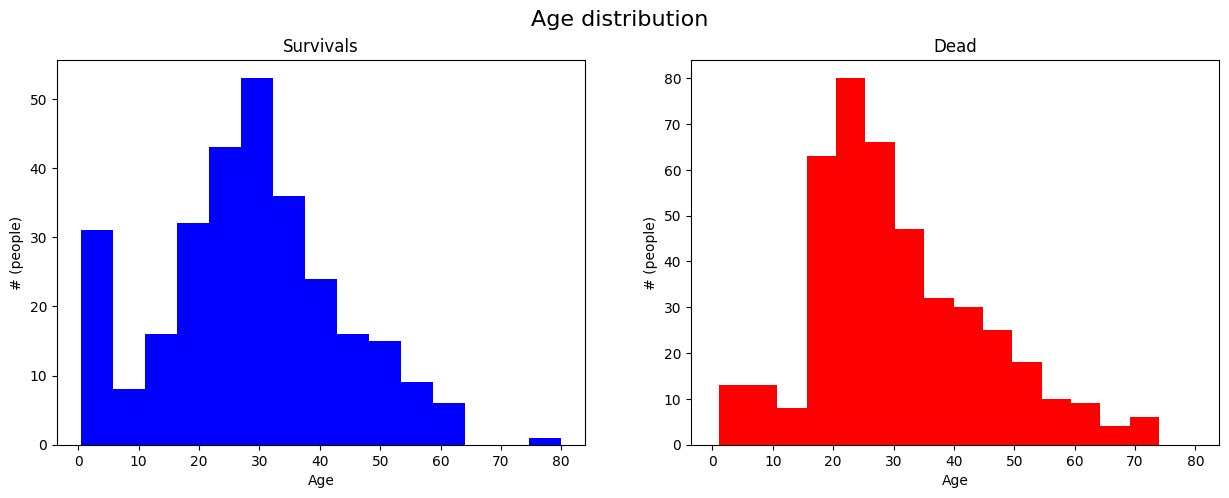

In [100]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(15,5), sharex=True)
plt.suptitle("Age distribution", size=16)

ax[0].set_title("Survivals")
ax[0].hist(Survivors['Age'], bins=15, color='blue')
ax[0].set(xlabel ="Age" , ylabel = "# (people)")

ax[1].set_title("Dead")
ax[1].hist(Dead['Age'], bins=15, color='red')
ax[1].set(xlabel ="Age" , ylabel = "# (people)");

##### 3)
*   Select the features corresponding to the Fare and to the Survival
*   Eliminate artifacts
*   Compute the difference between the average fare of the two groups

In [113]:
data1 = data_raw[['Fare', 'Survived']]
data1 = data1.dropna(axis=0, how='any')

# Compute the difference
Survivors1 = data1[data1['Survived'] == 1]
Dead1 = data1[data1['Survived'] == 0]

meanFare_S = Survivors1['Fare'].mean()
meanFare_D = Dead1['Fare'].mean()
diffMean = meanFare_S - meanFare_D
print(f"The differences between the average of the fare of survived and death person is {diffMean:.3f}")

The differences between the average of the fare of survived and death person is 26.278


##### 4) Use Resampling to test the **Null hypothesis**

In [118]:
import numpy as np

# Create a global list
glob = list(Survivors1['Fare']) + list(Dead1['Fare'])
len_S = len(Survivors1)
len_D = len(Dead1)

import random
trials = 10000
count = 0

for i in range(trials):
    # Shuffle the fares
    random.shuffle(glob)
    # Compute the average of group A
    avg_A = np.mean(glob[:len_S]) # first group saved
    avg_B = np.mean(glob[len_S:]) # second group dead
    # Compute the difference in average
    diff = avg_A - avg_B
    if diff > diffMean:
        count += 1

print(f"The difference in fares between group A and group B was bigger {count} times respect to the actual survivors vs died difference")


The difference in fares between group A and group B was bigger 0 times respect to the actual survivors vs died difference


We could safely $\textbf{reject}$ the null hypothesis 

##### 5) Concentrate on the Fare feature and compute the median correspondent to the two groups

In [124]:
def median(V):
    len = np.size(V)
    V = np.sort(V)
    if (len % 2 == 0):
        median = (V[len//2] + V[(len//2)+1]) / 2
    else:
        median = V[len//2]
    return median
S = Survivors1['Fare']
D = Dead1['Fare']
print(f"Median value of survivor: ", median(S))
print(f"Median value of died: ", median(D))

Median value of survivor:  26.0
Median value of died:  10.5


##### 6) Now we use **bootstrap** for each of the two groups: 

* Sample the Fares 10000 times with replacement (with the same sample size) using `np.random.choice`
* Compute the Confidence Interval (95%) for the median using `np.percentile`

In [128]:
reps = 10000
np.random.seed(123)

# SURVIVED
n_S = len(S)
boot_S = np.random.choice(S, (reps,n_S))
boot_S_medians = np.median(boot_S, axis=1) # axis=0: per column, axis=1: per row
boot_S_median_CI = np.percentile(boot_S_medians, [2.5,97.5])
print(f"The C.I. for the median fare of the survival computed with bootstrap is [{boot_S_median_CI[0]},{boot_S_median_CI[1]}]")

# DIED
n_D = len(D)
boot_D = np.random.choice(D, (reps,n_D))
boot_D_medians = np.median(boot_D, axis=1)
boot_D_median_CI = np.percentile(boot_D_medians, [2.5,97.5])
print(f"The C.I. for the median fare of the died computed with bootstrap is [{boot_D_median_CI[0]},{boot_D_median_CI[1]}]")


The C.I. for the median fare of the survival computed with bootstrap is [23.0,26.55]
The C.I. for the median fare of the died computed with bootstrap is [9.2167,13.0]


##### 7)

* Plot the median rate distribution, including the relative confidence intervals
* What can we say?

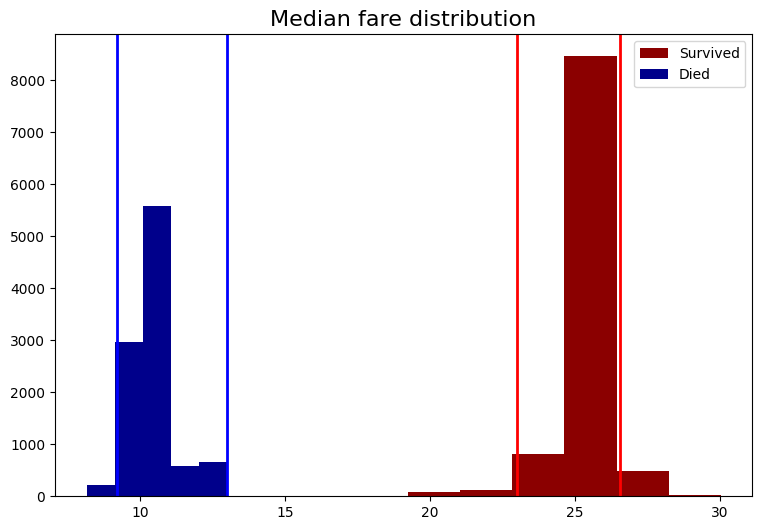

In [138]:
# import matplotlib.pyplot as plt (already done)

# Now I want to plot on the same x axis, so I'm not creating two subplot
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
plt.title("Median fare distribution", size=16)
ax.hist(boot_S_medians,bins=6,color='darkred', label="Survived")
plt.axvline(boot_S_median_CI[0],color='red',linewidth=2)
plt.axvline(boot_S_median_CI[1],color='red',linewidth=2)
ax.hist(boot_D_medians,bins=5, color='darkblue', label="Died")
plt.axvline(boot_D_median_CI[0],color='blue',linewidth=2)
plt.axvline(boot_D_median_CI[1],color='blue',linewidth=2)
ax.legend();

##### 8) Use bootstrap to compute the variance of the medians of the two groups

In [139]:
boot_S_median_variance = np.var(boot_S_medians)
boot_D_median_variance = np.var(boot_D_medians)

print("The variance for the median fare of Survivers computed with bootstrap is {:.3f}, while for the dead is {:.3f} ".format(boot_S_median_variance,boot_D_median_variance))

The variance for the median fare of Survivers computed with bootstrap is 0.996, while for the dead is 0.696 


#### **Other features**

Now we analyse the impact of other features on the survival of the passengers:

* **Sex**
* **Pclass**$\;\in\{1,2,3\}$ is the passenger-class

##### Compute the following conditional probabilities:

* $P(Survived=1\;|\; Sex = female)$
* $P(Survived=1\;|\; Sex = male)$

##### Compute the following conditional probabilities:

* $P(Survived=1\;|\; Sex = male\;,\; Pclass = 1)$
* $P(Survived=1\;|\; Sex = male\;,\; Pclass = 2)$
* $P(Survived=1\;|\; Sex = male\;,\; Pclass = 3)$

After finding the values of $Pclass$ corresponding to the highest and the lowest value of survival rate, test the hypothesis that the difference is due to the limited number of data.